In [33]:
# Task 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [35]:
# Function Definitions
def detect_outliers_in_column(column):
    """
    Detect outliers in a specific column using the Interquartile Range (IQR) method.
    Replaces outliers with the column's median value.
    
    Args:
        column: A pandas Series representing a column in the dataset.

    Returns:
        The column with outliers replaced by the median value.
    """
    Q1 = column.quantile(0.25)  # First quartile (25th percentile)
    Q3 = column.quantile(0.75)  # Third quartile (75th percentile)
    score = Q3 - Q1  # Interquartile range (IQR) as a measure of spread
    bound_l = Q1 - 1.5 * score  # Lower bound for detecting outliers (1.5 times below Q1)
    bound_u = Q3 + 1.5 * score  # Upper bound for detecting outliers (1.5 times above Q3)
    median = column.median()  # Median of the column to replace outliers
    # Replace values outside of the calculated bounds (outliers) with the median value
    column = np.where((column < bound_l) | (column > bound_u), median, column)
    return column  # Return the column with outliers replaced

def detect_outliers_dataset(data_with_outliers):
    """
    Detect and handle outliers for all numeric columns in a dataset.
    
    Args:
        data_with_outliers: A pandas DataFrame that may contain outliers.

    Returns:
        DataFrame with outliers handled (replaced with median) for all numeric columns.
    """
    # Loop over each numeric column in the dataset (selecting only float and integer columns)
    for column in data_with_outliers.select_dtypes(include=['float64', 'int64', 'int8']).columns:
        # Replace outliers in each numeric column using the detect_outliers_in_column function
        data_with_outliers[column] = detect_outliers_in_column(data_with_outliers[column])
    return data_with_outliers  # Return the modified DataFrame with no outliers

def uncorrelated_cols(matrix, col, filter):
    """
    Identify columns that are uncorrelated with a target column, based on a correlation filter.
    
    Args:
        matrix: A correlation matrix (pandas DataFrame).
        col: The column name (target) to find uncorrelated columns against.
        filter: The threshold for correlation; columns with an absolute correlation
                below this threshold are considered uncorrelated.

    Returns:
        A list of column names that are uncorrelated with the target column.
    """
    uncorrelated = []  # Initialize a list to store uncorrelated columns
    # Sort the correlations of all columns with respect to the target column (descending)
    cols = matrix[col].sort_values(ascending=False)
    # Loop over all columns and check if their correlation is below the filter value
    for i in range(len(cols)):
        if abs(cols[i]) < filter:  # If absolute correlation is below threshold
            uncorrelated.append(cols.keys()[i])  # Append the column to the uncorrelated list
    return uncorrelated  # Return the list of uncorrelated columns

def Plot_Correlation(data_set, name):
    """
    Plot a correlation matrix heatmap for the given dataset.

    Args:
        data_set: A pandas DataFrame for which to compute and plot the correlation matrix.
        name: A string representing the name of the dataset (used for plot title).

    Returns:
        The computed correlation matrix.
    """
    matrix = data_set.corr()  # Compute correlation matrix between features
    plt.figure(figsize=(10, 8))  # Set plot size to a readable dimension
    sns.heatmap(matrix, annot=True, cmap='coolwarm')  # Plot heatmap with annotations and coolwarm colormap
    plt.title(f'Correlation Matrix Heatmap: {name}')  # Set title using the provided dataset name
    plt.show()  # Display the correlation heatmap
    return matrix  # Return the computed correlation matrix

def train_test_split(X, y, test_size=0.2, random_seed=42):
    """
    Perform train-test split on the dataset with the given test size.
    
    Args:
        X: Features (input data) as a numpy array.
        y: Target (output data) as a numpy array.
        test_size: Fraction of the dataset to be used for testing (default is 20%).
        random_seed: Random seed for reproducibility (default is 42).

    Returns:
        Four arrays: X_train, X_test, y_train, y_test
    """
    np.random.seed(random_seed)  # Set random seed for reproducibility
    indices = np.random.permutation(len(X))  # Shuffle the dataset indices randomly
    test_size = int(len(X) * test_size)  # Calculate the size of the test set
    test_indices = indices[:test_size]  # Select test set indices
    train_indices = indices[test_size:]  # Select training set indices
    # Split the dataset into training and testing sets and return them
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

class BatchNormalization:
    """
    Batch normalization class to normalize data using mean and variance.
    """
    def __init__(self):
        self.epsilon = 1e-8  # A small value to avoid division by zero during normalization

    def normalize(self, X):
        """
        Normalize the dataset using batch normalization.
        
        Args:
            X: Input data to be normalized (numpy array).

        Returns:
            Normalized dataset (numpy array).
        """
        mean = np.mean(X, axis=0)  # Compute mean of each feature (column-wise)
        variance = np.var(X, axis=0)  # Compute variance of each feature (column-wise)
        # Normalize the input data using batch normalization formula
        X_normalized = (X - mean) / np.sqrt(variance + self.epsilon)
        return X_normalized  # Return the normalized data

def xavier_weight_initialization(input_dim):
    """
    Xavier weight initialization method, which initializes weights to values
    based on the number of input dimensions to prevent exploding or vanishing gradients.
    
    Args:
        input_dim: Number of input dimensions (features).

    Returns:
        A numpy array of initialized weights.
    """
    limit = np.sqrt(6 / input_dim)  # Compute the Xavier initialization range based on input dimensions
    # Initialize weights randomly between -limit and limit
    return np.random.uniform(-limit, limit, input_dim)  # Return the initialized weights

class ElasticNetRegression:
    """
    Elastic Net Regression model, a linear regression model that includes
    both L1 (Lasso) and L2 (Ridge) regularization.
    """
    def __init__(self, learning_rate=0.005, epochs=1000, lambda_1=0.001, lambda_2=0.001, w_method="random", threshold=None):
        """
        Initialize the ElasticNetRegression model with given hyperparameters.
        
        Args:
            learning_rate: Step size for gradient descent updates (default 0.005).
            epochs: Number of iterations to run gradient descent (default 1000).
            lambda_1: Regularization parameter for L2 (Ridge) penalty (default 0.001).
            lambda_2: Regularization parameter for L1 (Lasso) penalty (default 0.001).
            w_method: Method to initialize weights ('random', 'zero', or 'xavier').
            threshold: Threshold for early stopping based on gradient magnitudes.
        """
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.lambda_1 = lambda_1  # L2 regularization parameter
        self.lambda_2 = lambda_2  # L1 regularization parameter
        self.w = None  # Initialize weights as None
        self.b = None  # Initialize bias as None
        self.w_method = w_method  # Set weight initialization method
        self.threshold = threshold  # Set threshold for early stopping (if any)
        self.loss_history = []  # Track loss values over epochs

    def _compute_loss(self, X, y):
        """
        Compute the loss (cost function) with regularization.
        
        Args:
            X: Feature matrix (numpy array).
            y: Target values (numpy array).

        Returns:
            Regularized loss value (float).
        """
        N = len(y)  # Number of samples
        y_pred = np.dot(X, self.w) + self.b  # Linear prediction
        # Compute Mean Squared Error loss and add regularization terms for L1 and L2
        return (1 / (2 * N)) * np.sum((y_pred - y) ** 2) + (self.lambda_1 / 2) * np.sum(self.w ** 2) + self.lambda_2 * np.sum(np.abs(self.w))

    def _compute_gradient(self, X, y):
        """
        Compute the gradients for weights and bias.
        
        Args:
            X: Feature matrix (numpy array).
            y: Target values (numpy array).

        Returns:
            Gradient for weights (numpy array), Gradient for bias (float).
        """
        N = len(y)  # Number of samples
        y_pred = np.dot(X, self.w) + self.b  # Linear prediction
        error = y_pred - y  # Calculate error
        # Compute gradients for weights and bias with L1 and L2 regularization
        return ((1 / N) * np.dot(X.T, error) + self.lambda_1 * self.w + self.lambda_2 * np.sign(self.w)), ((1 / N) * np.sum(error))

    def _initialize_weights(self, n_features):
        """
        Initialize the weights and bias based on the selected method.
        
        Args:
            n_features: Number of features (input dimensions).
        """
        if self.w_method == "random":
            self.w = np.random.rand(n_features)  # Initialize with random values
        elif self.w_method == "zero":
            self.w = np.zeros(n_features)  # Initialize with zeros
        elif self.w_method == "xavier":
            self.w = xavier_weight_initialization(n_features)  # Use Xavier initialization
        self.b = 0  # Initialize bias to zero

    def fit(self, X, y):
        """
        Train the ElasticNetRegression model using gradient descent.
        
        Args:
            X: Feature matrix (numpy array).
            y: Target values (numpy array).
        """
        N, n_features = X.shape  # Get number of samples and features
        self._initialize_weights(n_features)  # Initialize weights based on the method

        # Perform gradient descent for the specified number of epochs
        for epoch in range(self.epochs):
            dw, db = self._compute_gradient(X, y)  # Compute gradients for weights and bias
            self.w -= self.learning_rate * dw  # Update weights
            self.b -= self.learning_rate * db  # Update bias

            loss = self._compute_loss(X, y)  # Compute loss (cost function)
            self.loss_history.append(loss)  # Record loss at each epoch

            # Early stopping condition if gradients fall below the threshold
            if self.threshold is not None and np.all(np.abs(dw) < self.threshold):
                print(f'Stopping early at epoch {epoch}, gradient below threshold')
                break

    def predict(self, X):
        """
        Predict the target values for given feature matrix.
        
        Args:
            X: Feature matrix (numpy array).
        
        Returns:
            Predicted target values (numpy array).
        """
        return np.dot(X, self.w) + self.b  # Linear prediction using trained weights and bias

def plot_combined_loss(loss_histories, sets, clip=None):
    """
    Plot the loss history over epochs for different parameter sets.
    
    Args:
        loss_histories: A list of loss histories from different models.
        sets: A list of parameter set names (for labeling the plot).
        clip: Optional argument to limit the x-axis (number of epochs shown).
    """
    plt.figure(figsize=(10, 6))  # Set figure size for the plot
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray']  # Color map
    
    # Loop over each loss history and plot it with a different color
    for i, loss_history in enumerate(loss_histories):
        plt.plot(loss_history, label=f'{sets[i]}', color=colors[i % len(colors)])  # Plot loss history

    plt.title('Loss over Epochs for Various Parameter sets')  # Set plot title
    if clip is not None:
        plt.xlim(0, clip)  # Limit x-axis if clip is specified
    plt.grid(True)  # Add grid to the plot
    plt.xlabel('Epoch')  # Label x-axis
    plt.ylabel('Loss')  # Label y-axis
    plt.legend()  # Show legend for different parameter sets
    plt.show()  # Display the plot

def plot_predictions(y_test, y_pred, label):
    """
    Plot actual vs predicted values in a scatter plot.
    
    Args:
        y_test: Actual target values (numpy array).
        y_pred: Predicted target values (numpy array).
        label: Label for the plot (string).

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))  # Set figure size for the plot
    plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7, label=f'{label}')  # Scatter plot of actual vs predicted values
    # Plot a line representing ideal predictions (perfect correlation)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')
    plt.xlabel('Actual Values')  # Label x-axis
    plt.ylabel('Predicted Values')  # Label y-axis
    plt.title(f'Actual vs Predicted - {label}')  # Set plot title
    plt.legend()  # Show legend
    plt.show()  # Display the plot

def train_model(X_train, X_test, y_train, y_test, w_method, learning_rate, epochs, threshold):
    """
    Train the ElasticNetRegression model and evaluate its performance.
    
    Args:
        X_train: Training feature matrix (numpy array).
        X_test: Testing feature matrix (numpy array).
        y_train: Training target values (numpy array).
        y_test: Testing target values (numpy array).
        w_method: Weight initialization method ('random', 'zero', 'xavier').
        learning_rate: Learning rate for gradient descent.
        epochs: Number of epochs for training.
        threshold: Threshold for early stopping.

    Returns:
        loss_history: Loss history over epochs.
        y_pred: Predicted values for the test set.
        best_loss: Best (minimum) loss value achieved during training.
    """
    # Initialize the ElasticNetRegression model with specified parameters
    model = ElasticNetRegression(learning_rate=learning_rate, epochs=epochs, lambda_1=0.0005, lambda_2=0.0005, w_method=w_method, threshold=threshold)
    model.fit(X_train, y_train)  # Train the model
    best_loss = min(model.loss_history)  # Find the minimum loss achieved during training
    y_pred = model.predict(X_test)  # Make predictions on the test set
    mse = np.mean((y_pred - y_test) ** 2)  # Calculate Mean Squared Error for predictions
    print(f"Mean Squared Error: {mse}, Regularized Best Loss: {best_loss}")  # Print MSE and best loss
    return model.loss_history, y_pred, best_loss  # Return loss history, predictions, and best loss


In [37]:
"""
Reading Red and White wine CSV files
"""
raw_data_redwine = pd.read_csv('winequality-red.csv', sep=";")
raw_data_whitewine = pd.read_csv('winequality-white.csv', sep=";")

In [39]:
"""
Adding a new column named type to add a new feature
"""
raw_data_redwine['type'] = 'red'
raw_data_whitewine['type'] = 'white'

In [41]:
"""
Joining two dataframes to create a single dataset
"""
raw_data_wine = pd.concat([raw_data_whitewine, raw_data_redwine], ignore_index=True)

In [43]:
"""
Information about the datatypes and null values
"""
raw_data_wine.info()
raw_data_wine.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

In [45]:
"""
Eliminating the outliers in the dataset
"""
wine_data_olfree = detect_outliers_dataset(raw_data_wine)
wine_data_olfree

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.270,0.36,3.0,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6.0,white
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6.0,white
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6.0,white
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,white
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5.0,red
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0,red
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6.0,red
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5.0,red


In [47]:
"""
One hot encoding to convert the newly added feature to numerical
"""
wine_data_encoded = pd.get_dummies(raw_data_wine, columns=['type'], drop_first=True)
wine_data_encoded.rename(columns={'type_white': 'type'}, inplace=True)
wine_data_encoded['type'] = wine_data_encoded['type'].astype(int)
wine_data_encoded

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.270,0.36,3.0,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6.0,1
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6.0,1
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6.0,1
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,1
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5.0,0
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0,0
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6.0,0
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5.0,0


In [55]:
"""
Saving the preprocessed dataset without splitting the dataset
"""
wine_data_encoded.to_csv('winequality_preprocessed.csv', index=False)

In [57]:
"""
Identify the Uncorrelated columns with respect to given target
"""
target = 'pH'
drop_columns = uncorrelated_cols(wine_data_encoded.corr(), target, 0.1)
drop_columns.append(target)
drop_columns

/var/folders/ht/vhh4hxzn1614ncvj77svrnpr0000gn/T/ipykernel_65945/1345582570.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(cols[i]) < filter:  # If absolute correlation is below threshold


['quality', 'density', 'pH']

In [59]:
"""
Drop uncorrelated features,
Split the dataset,
print the shapes of the train and test datasets
"""
X = wine_data_encoded.drop(columns=drop_columns)
y = wine_data_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2)
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}\n')

X_train Shape: (5198, 10)
X_test Shape: (1299, 10)
y_train Shape: (5198,)
y_test Shape: (1299,)



In [61]:
"""
Batch Normalization for the Input test and train
"""
batch_norm = BatchNormalization()
X_train_normalized = batch_norm.normalize(X_train)
X_test_normalized = batch_norm.normalize(X_test)

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=0.001, Epochs=1000, Init=xavier
Mean Squared Error: 0.02637460399685979, Regularized Best Loss: 0.014346428971082629


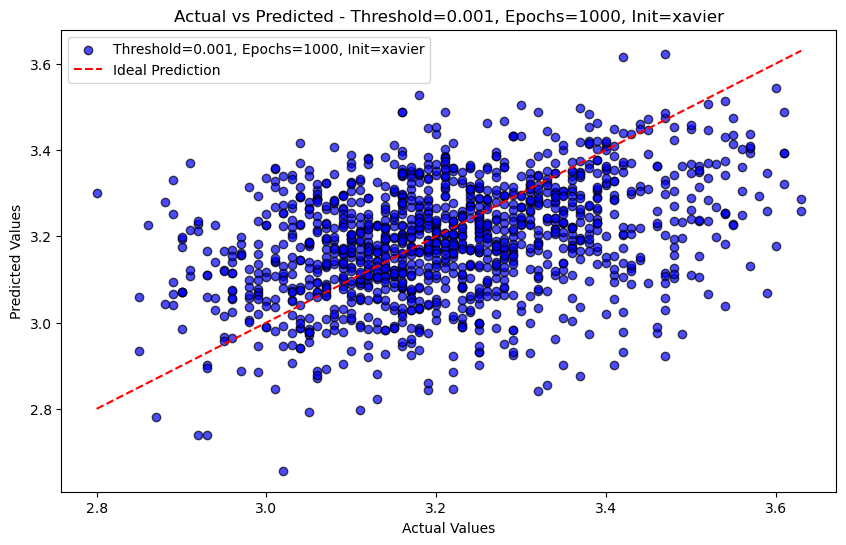

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=0.001, Epochs=1000, Init=random
Mean Squared Error: 0.05545984951853643, Regularized Best Loss: 0.028657412981584675


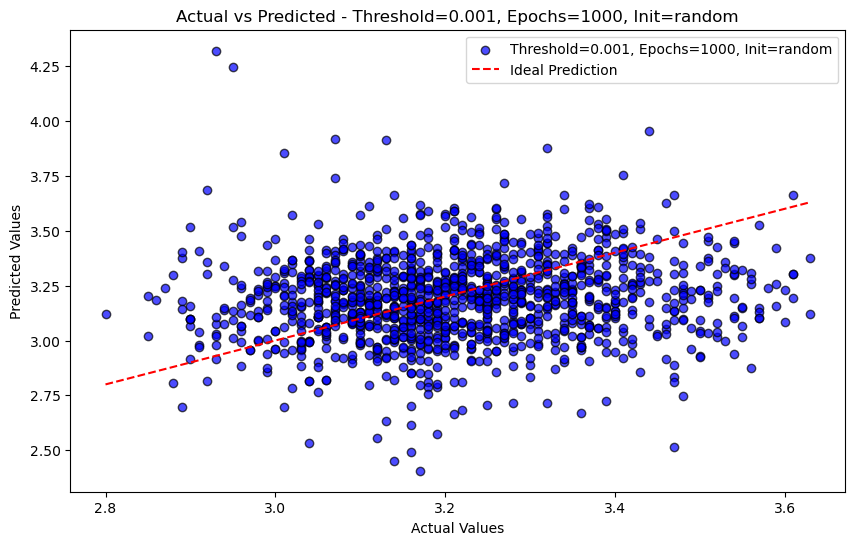

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=0.001, Epochs=1000, Init=zero
Mean Squared Error: 0.016929404502883, Regularized Best Loss: 0.008855917602653772


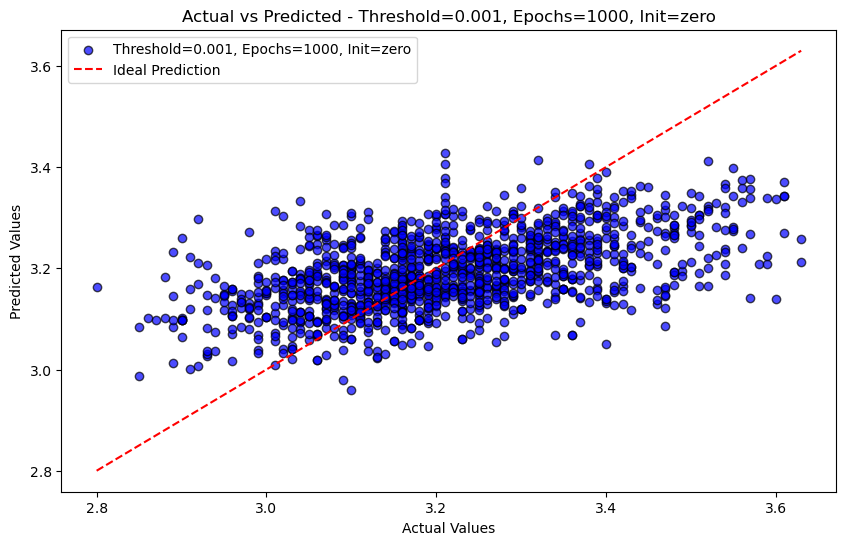

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=0.001, Epochs=5000, Init=xavier
Stopping early at epoch 3655, gradient below threshold
Mean Squared Error: 0.016376170730645193, Regularized Best Loss: 0.008597058696549482


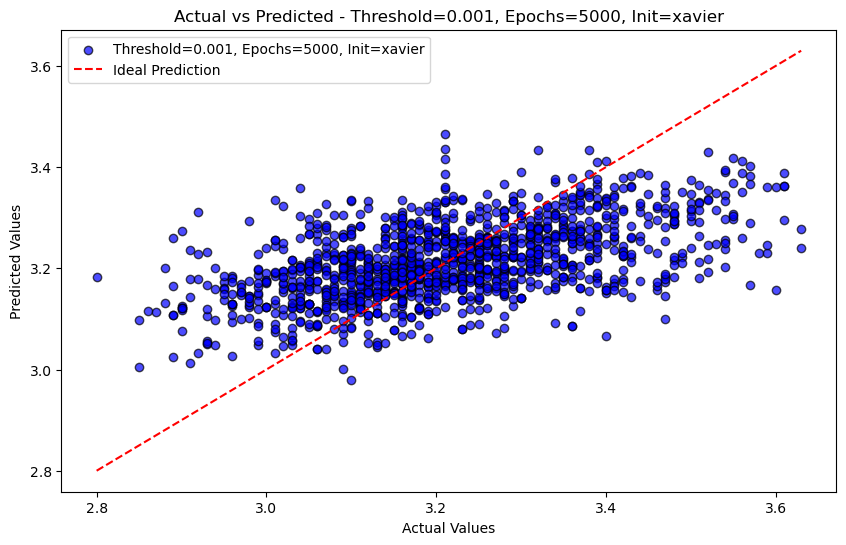

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=0.001, Epochs=5000, Init=random
Mean Squared Error: 0.016385490786028235, Regularized Best Loss: 0.008600683767273154


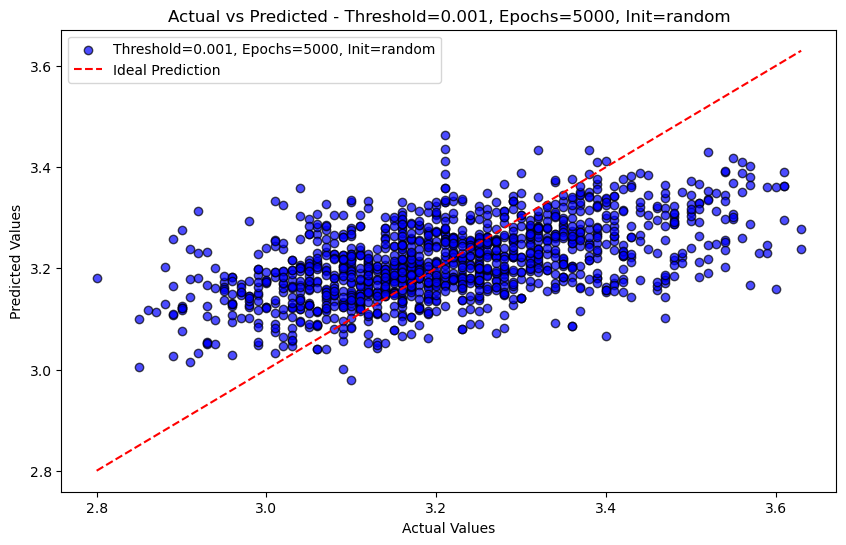

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=0.001, Epochs=5000, Init=zero
Stopping early at epoch 2268, gradient below threshold
Mean Squared Error: 0.016376029663950204, Regularized Best Loss: 0.008597105719892084


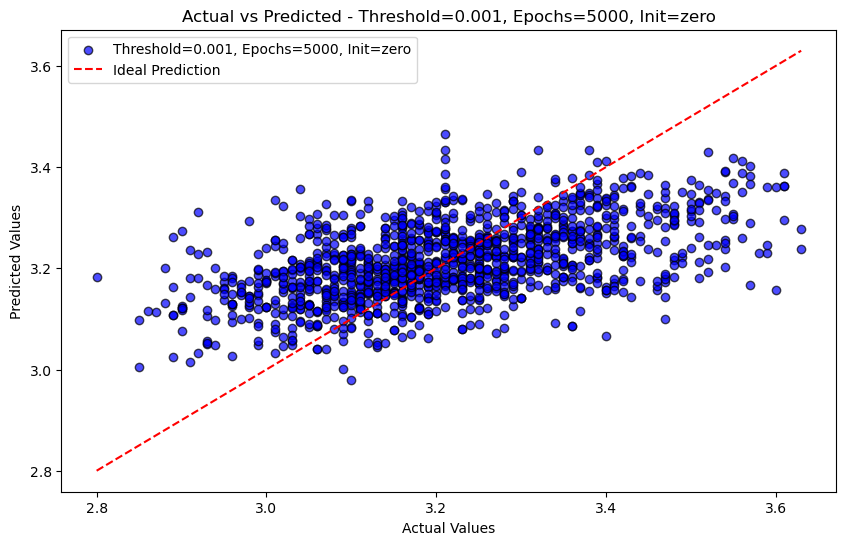

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=None, Epochs=1000, Init=xavier
Mean Squared Error: 0.01865002194972085, Regularized Best Loss: 0.009656593658526077


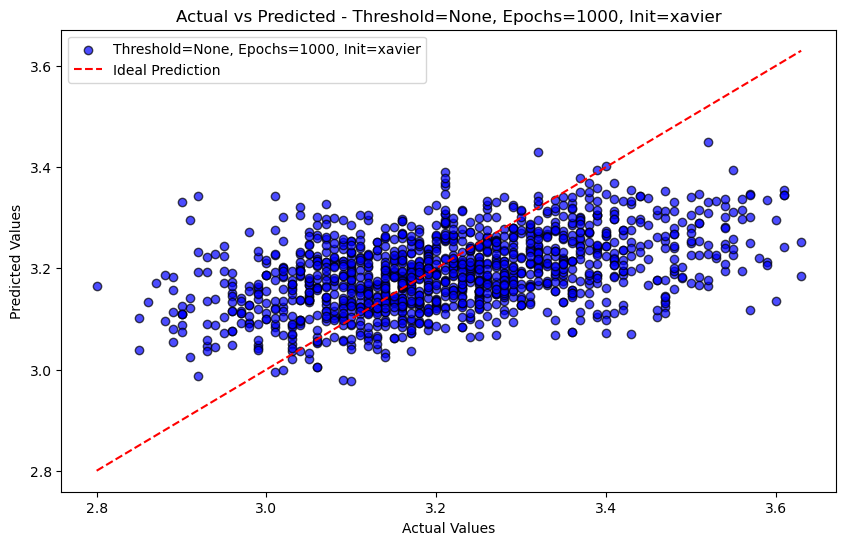

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=None, Epochs=1000, Init=random
Mean Squared Error: 0.06937577945800957, Regularized Best Loss: 0.03568139967730284


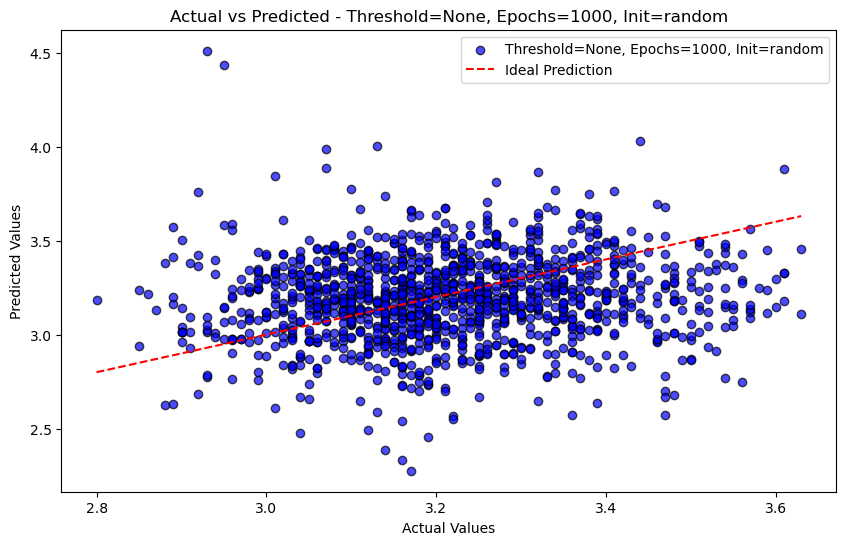

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=None, Epochs=1000, Init=zero
Mean Squared Error: 0.016929404502883, Regularized Best Loss: 0.008855917602653772


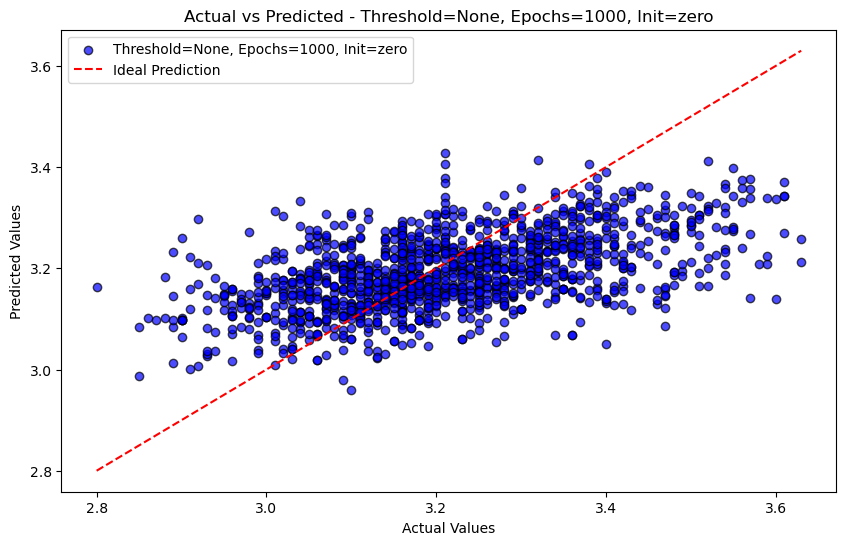

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=None, Epochs=5000, Init=xavier
Mean Squared Error: 0.016408489942637664, Regularized Best Loss: 0.008610965154420443


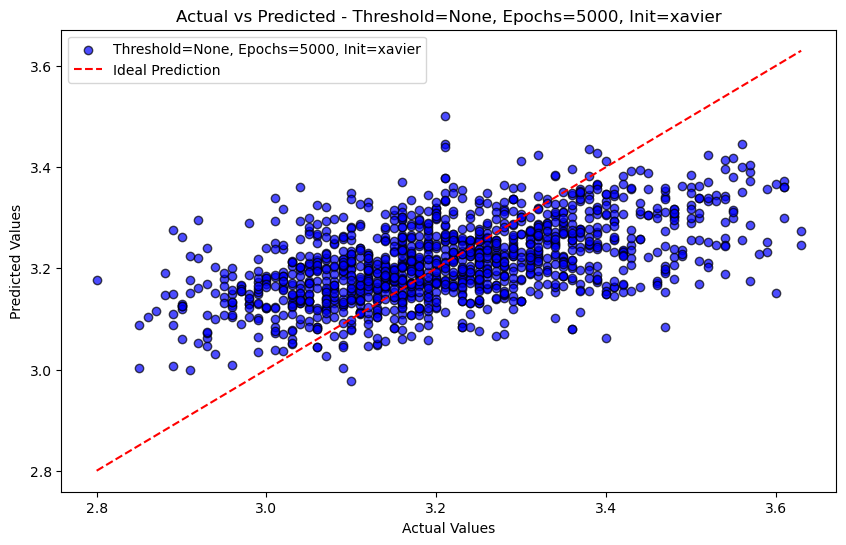

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=None, Epochs=5000, Init=random
Mean Squared Error: 0.016381692730008127, Regularized Best Loss: 0.008599200399668211


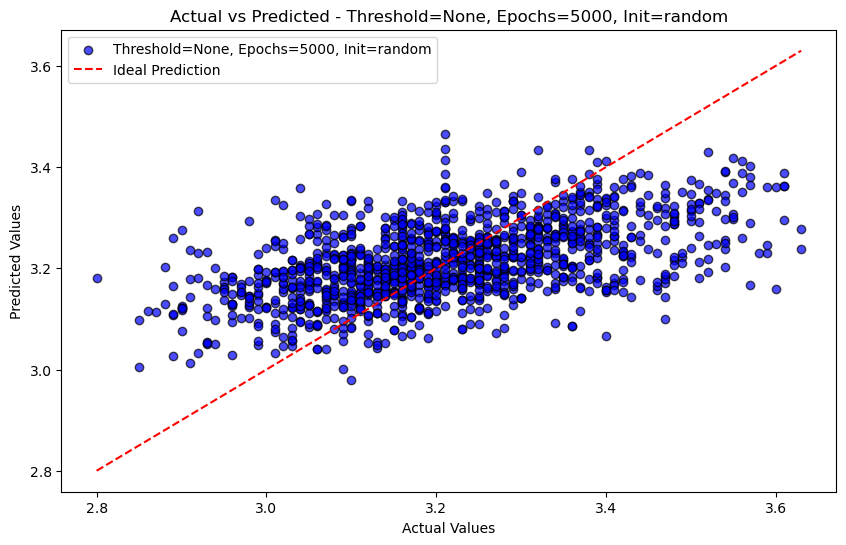

----------------------------------------------------------------------------------------------------------------------
Running for: Threshold=None, Epochs=5000, Init=zero
Mean Squared Error: 0.016366851660354485, Regularized Best Loss: 0.008589894857044209


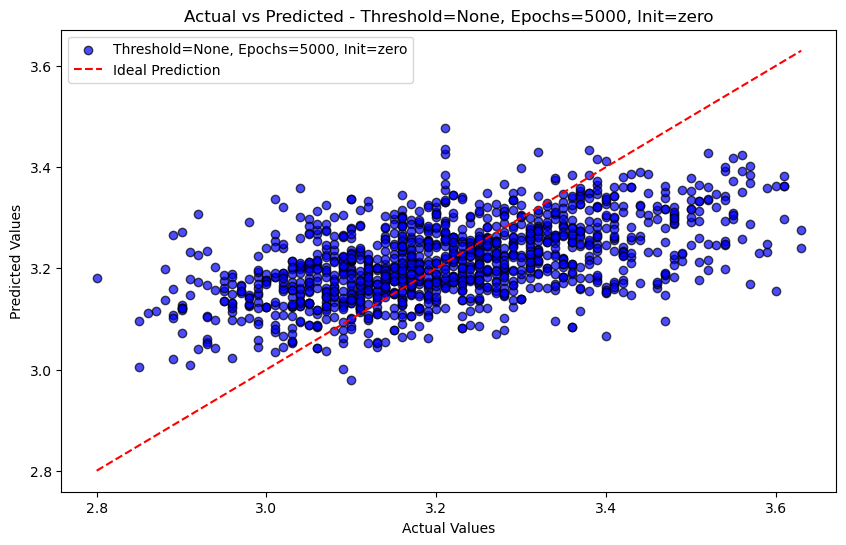

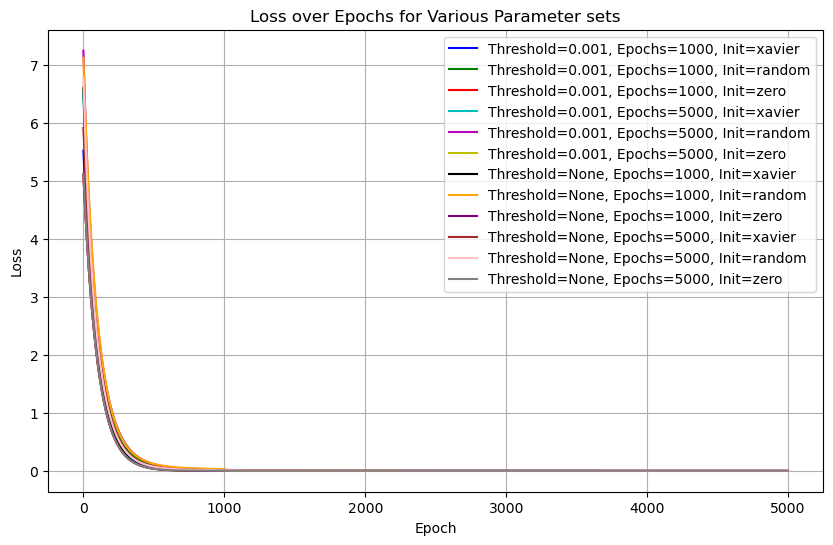


Best Hyperparameter Set:
Threshold: None, Epochs: 5000, Weight Initialization: zero
Best Loss: 0.008589894857044209
Best model weights, bias, and hyperparameter combination saved to npulla2_bgutha_assignment1_part4.pkl


In [63]:
# Define the possible values for thresholds, epochs, and weight initialization methods
thresholds = [0.001, None]  # Thresholds for early stopping (0.001 or None for no early stopping)
epochs_list = [1000, 5000]  # Number of epochs (iterations) for training
weight_initializations = ['xavier', 'random', 'zero']  # Different methods for initializing weights

# Prepare to store loss histories and corresponding parameter sets for later visualization
loss_histories = []  # To store loss history of each parameter combination
sets = []  # To store the string labels of each parameter combination
best_loss_global = float('inf')  # Initialize the global best loss as infinity (to minimize)
best_params = None  # To store the best hyperparameter combination
best_model = None  # Prepare to store the best model

# Nested loops to iterate through all combinations of hyperparameters
for threshold in thresholds:  # Loop through the thresholds for early stopping
    for epochs in epochs_list:  # Loop through the number of epochs
        for w_method in weight_initializations:  # Loop through the weight initialization methods
            # Create a label for this combination of parameters for identification in the plot and printout
            label = f"Threshold={threshold}, Epochs={epochs}, Init={w_method}"
            print("----------------------------------------------------------------------------------------------------------------------")
            print(f"Running for: {label}")  # Print the label for the current set of hyperparameters

            # Train the ElasticNetRegression model with the current set of hyperparameters
            # Capture the loss history, predictions, and best loss for this combination
            loss_history, y_pred, best_loss = train_model(
                X_train_normalized, X_test_normalized, y_train, y_test, 
                w_method, learning_rate=0.005, epochs=epochs, threshold=threshold
            )
            
            # Append the loss history and label to their respective lists for plotting later
            loss_histories.append(loss_history)  # Store loss history for this parameter set
            sets.append(label)  # Store the label for this parameter set

            # Plot the actual vs predicted values for the current parameter set
            plot_predictions(y_test, y_pred, label)  # Visual comparison of predictions vs actual values

            # Check if the current combination produces the lowest loss so far
            if best_loss < best_loss_global:
                # If the current best loss is better than the global best, update the global best loss
                best_loss_global = best_loss
                # Also store the corresponding hyperparameters for this best loss
                best_params = {
                    'Threshold': threshold,  # Store threshold
                    'Epochs': epochs,  # Store number of epochs
                    'Weight Initialization': w_method  # Store weight initialization method
                }
                best_model = ElasticNetRegression(learning_rate=0.005, epochs=epochs, lambda_1=0.0005, lambda_2=0.0005, w_method=w_method, threshold=threshold)
                best_model.fit(X_train_normalized, y_train)  # Re-train the best model
                best_weights = best_model.w  # Store the best model's weights
                best_bias = best_model.b  # Store the best model's bias

# Plot the combined loss histories for all parameter sets
plot_combined_loss(loss_histories, sets)

# Print the best hyperparameter set and the corresponding best loss
print("\nBest Hyperparameter Set:")
print(f"Threshold: {best_params['Threshold']}, Epochs: {best_params['Epochs']}, Weight Initialization: {best_params['Weight Initialization']}")
print(f"Best Loss: {best_loss_global}")

# Save the best model weights, bias, and hyperparameter set to a pickle file
best_model_data = {
    'Best Weights': best_weights,  # Save the best weights
    'Best Bias': best_bias,  # Save the best bias
    'Best Hyperparameters': best_params,  # Save the best hyperparameters
    'Best Loss': best_loss_global  # Save the best loss
}

# Specify the filename for the pickle file
pickle_filename = 'npulla2_bgutha_assignment1_part4.pkl'

# Save the dictionary as a pickle file
with open(pickle_filename, 'wb') as file:
    pickle.dump(best_model_data, file)

print(f"Best model weights, bias, and hyperparameter combination saved to {pickle_filename}")